In [14]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

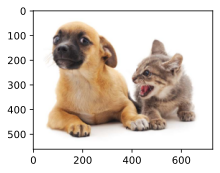

In [3]:
d2l.set_figsize()
img=d2l.plt.imread('C:/Users/Administrator/Desktop/catanddog.jpg')
d2l.plt.imshow(img)

In [11]:
def box_corner_to_center(boxes):
    """从（左上右下）转换成（中间宽度和高度）的表示"""
    x1,y1,x2,y2=boxes[:,0],boxes[:,1],boxes[:,2],boxes[:,3]
    cx=(x1+x2)/2
    cy=(y1+y2)/2
    w=x2-x1
    h=y2-y1
    boxes=torch.stack((cx,cy,w,h),axis=-1)
    return boxes
def box_center_to_corner(boxes):
    cx,cy,w,h=boxes[:,0],boxes[:,1],boxes[:,2],boxes[:,3]
    x1=cx-0.5*w
    x2=cx+0.5*w
    y1=cy-0.5*h
    y2=cy+0.5*h
    boxes=torch.stack((x1,y1,x2,y2),axis=-1)
    return boxes

In [12]:
dog_bbox,cat_bbox=[60.0,45,378,516],[400.0, 112.0, 655.0, 493.0]
boxes=torch.tensor((dog_bbox,cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

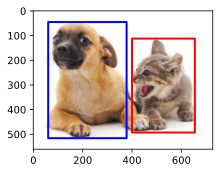

In [13]:
# 将边界框在图中画出
def bbox_to_rect(bbox,color):
    return d2l.plt.Rectangle(xy=(bbox[0],bbox[1]),width=bbox[2]-bbox[0],     
                            height=bbox[3] - bbox[1], fill=False,
                            edgecolor=color,linewidth=2)

fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox,'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox,'red'))

In [15]:
d2l.DATA_HUB['banana-detection'] = (d2l.DATA_URL + 'banana-detection.zip','5de25c8fce5ccdea9f91267273465dc968d20d72')               

In [29]:
def read_data_bananas(is_train=True):
    """读取香蕉数据集中的图像和标签"""
    data_dir=d2l.download_extract('banana-detection')
    csv_fname=os.path.join(data_dir,'bananas_train' if is_train else 'bananas_val','label.csv')
    csv_data=pd.read_csv(csv_fname)
    csv_data=csv_data.set_index('img_name') #将名为img_name的列设置为索引列
    images,targets=[],[]
    for img_name,target in csv_data.iterrows():
        images.append(torchvision.io.read_image(os.path.join(data_dir,'bananas_train' if is_train else 'bananas_val','images',f'{img_name}')))
        targets.append(list(target))
    print('len(targets):',len(targets))
    print('len(targets[0]):',len(targets[0]))
    print('targets[0][0]...targets[0][4]:',targets[0][0],targets[0][1],targets[0][2],targets[0][3],targets[0][4])
    print('type(targets):',type(targets))
    print("torch.tensor(targets).unsqueeze(1).shape：",torch.tensor(targets).unsqueeze(1).shape) # unsqueeze函数在指定位置加上维数为一的维度
    print("len(torch.tensor(targets).unsqueeze(1) / 256)：", len(torch.tensor(targets).unsqueeze(1) / 256))   
    print("type(torch.tensor(targets).unsqueeze(1) / 256)：", type(torch.tensor(targets).unsqueeze(1) / 256))   
    return images, torch.tensor(targets).unsqueeze(1) / 256 # 归一化使得收敛更快
"""这一操作的目的是进行归一化，使得数据的值范围在 0 到 1 之间。这对于许多机器学习和深度学习模型来说非常重要，因为归一化后的数据可以加速模型训练和提高模型性能。"""

'这一操作的目的是进行归一化，使得数据的值范围在 0 到 1 之间。这对于许多机器学习和深度学习模型来说非常重要，因为归一化后的数据可以加速模型训练和提高模型性能。'

In [30]:
#定义一个Dataset实例
class BananaDataset(torch.utils.data.Dataset):
    def __init__(self,is_train):
        self.features,self.labels=read_data_bananas(is_train)
        print('read'+str(len(self.features))+('train_examples' if is_train else 'validation examples'))
    def __getitem__(self,idx):
        return (self.features[idx].float(),self.labels[idx])
    def __len__(self):
        return len(self.features)

In [31]:
def load_data_bananas(batch_size):
    train_iter=torch.utils.data.DataLoader(BananaDataset(is_train=True),batch_size,shuffle=True)
    val_iter=torch.utils.data.DataLoader(BananaDataset(is_train=False),batch_size,shuffle=False)
    return train_iter,val_iter

In [33]:
#读取一个小批量，打印图像标签和形状
batch_size,edge_size=32,256
train_iter,_=load_data_bananas(batch_size)
batch=next(iter(train_iter))
batch[0].shape,batch[1].shape

len(targets): 1000
len(targets[0]): 5
targets[0][0]...targets[0][4]: 0 104 20 143 58
type(targets): <class 'list'>
torch.tensor(targets).unsqueeze(1).shape： torch.Size([1000, 1, 5])
len(torch.tensor(targets).unsqueeze(1) / 256)： 1000
type(torch.tensor(targets).unsqueeze(1) / 256)： <class 'torch.Tensor'>
read1000train_examples
len(targets): 100
len(targets[0]): 5
targets[0][0]...targets[0][4]: 0 183 63 241 112
type(targets): <class 'list'>
torch.tensor(targets).unsqueeze(1).shape： torch.Size([100, 1, 5])
len(torch.tensor(targets).unsqueeze(1) / 256)： 100
type(torch.tensor(targets).unsqueeze(1) / 256)： <class 'torch.Tensor'>
read100validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

In [43]:
# 示例
# pytorch里permute是改变参数维度的函数，
# Dataset里读的img维度是[batch_size, RGB, h, w]，
# 但是plt画图的时候要求是[h, w, RGB]，所以要调整一下

# 做图片的时候，一般是会用一个ToTensor()将图片归一化到【0, 1】，这样收敛更快
print("原始图片：",batch[0][0])
print("原始图片：",batch[0][0:10].permute(0,2,3,1))
print("归一化的图片：",(batch[0][0:10].permute(0,2,3,1))/255)

原始图片： tensor([[[152., 152., 159.,  ..., 249., 250., 245.],
         [155., 154., 159.,  ..., 247., 243., 249.],
         [157., 154., 157.,  ..., 245., 251., 249.],
         ...,
         [ 62.,  60.,  57.,  ..., 101., 101.,  96.],
         [111., 102.,  89.,  ..., 100.,  98.,  92.],
         [172., 172., 174.,  ..., 100.,  95.,  88.]],

        [[131., 132., 136.,  ..., 247., 250., 246.],
         [134., 134., 136.,  ..., 245., 243., 250.],
         [137., 134., 137.,  ..., 243., 251., 249.],
         ...,
         [104.,  99.,  94.,  ..., 128., 129., 124.],
         [150., 140., 122.,  ..., 127., 126., 120.],
         [209., 208., 205.,  ..., 127., 123., 115.]],

        [[  3.,   1.,   4.,  ..., 248., 252., 248.],
         [  6.,   3.,   4.,  ..., 246., 245., 252.],
         [  6.,   1.,   2.,  ..., 244., 253., 251.],
         ...,
         [ 20.,  18.,  16.,  ...,  11.,  16.,  13.],
         [ 93.,  83.,  67.,  ...,  10.,  15.,  10.],
         [165., 164., 163.,  ...,  10.,  13.,  

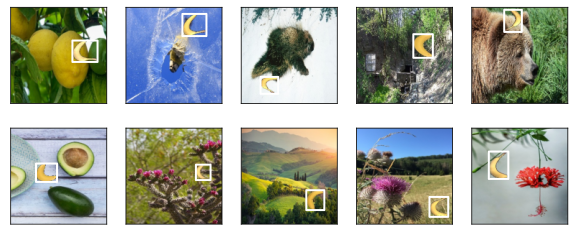

In [45]:
imgs=(batch[0][0:10].permute(0,2,3,1))/255
axes=d2l.show_images(imgs,2,5,scale=2)
for ax,label in zip(axes,batch[1][0:10]):
    d2l.show_bboxes(ax,[label[0][1:5]*edge_size],colors=['w'])